# Epidemiology Example

The Covid-19 Datalake provides line list records which have been crowd-sourced from data about known infections. Here, we show how to fetch the data from the Datalake, and plot the most common symptoms of these patients for various populations. 

## Load python modules

We first load the necessary python modules. We use `pandas`, `numpy`, and `matplotlib` as external libraries.

If you are connecting to C3 remotely, you will also need to have the `c3python` module.

In [1]:
# Load necessary Python Modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re

In [ ]:
try:
    # Check whether the c3 object is defined
    c3
except NameError:
    # Connect to a c3 cluster and create the c3 object
    from c3python import get_c3
    c3 = get_c3('<vanity_url>', '<tenant>', '<tag>')

## Fetch Line List data

Here, we fetch the line list data and select the number of features we want to gather from the dataset to reduce the amount of data we get. But first, let's check how many entries there are. C3 provides the convenient function `fetchCount` which does just that. You can pass a `FetchFilterSpec` which can do some filtering as well.

In [9]:
c3.LineListRecord.fetchCount()

2319103

Wow, that's a lot of results! (> 2 million when this guide was written!) Let's take a look at say 100 instances to see what the data looks like before getting all the data.

In [10]:
spec = {
    'include': 'symptoms, gender, age, ageRange, outcome, didDie, didRecover, caseConfirmationDate, outcomeDate, hospitalAdmissionDate',
    'limit': 100,
}

linelist_res = c3.LineListRecord.fetch(spec=spec)

In [17]:
pd.DataFrame(linelist_res.objs.toJson())

,type,id,meta,version,gender,caseConfirmationDate,outcome,didDie,didRecover,age,outcomeDate,hospitalAdmissionDate
0,LineListRecord,000-1-1,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,male,2020-02-14T00:00:00+00:00,"critical condition, intubated as of 14.02.2020",False,False,NaN,NaN,NaN
1,LineListRecord,000-1-10,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,male,2020-02-21T00:00:00+00:00,death,True,False,78.0,2020-02-22T00:00:00+00:00,NaN
2,LineListRecord,000-1-100,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,female,2020-02-14T00:00:00+00:00,discharge,False,True,61.0,2020-02-17T00:00:00+00:00,NaN
3,LineListRecord,000-1-1000,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,2020-01-26T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
4,LineListRecord,000-1-10000,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,2020-02-14T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
95,LineListRecord,000-1-10083,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,2020-02-07T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
96,LineListRecord,000-1-10084,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,2020-02-07T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
97,LineListRecord,000-1-10085,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,2020-02-07T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
98,LineListRecord,000-1-10086,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,2020-02-07T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN


Interesting, apparently lots of these entries do not have symptom information. Why don't we look at how many DO have symptom information. We'll use the `ExpressionEngineFunction` `exists` as part of our filter function. See `help(c3.ExpressionEngineFunction)` or more information about expression engine functions.

In [19]:
c3.LineListRecord.fetchCount(spec={'filter': 'exists(symptoms)'})

2388

That's far fewer than before. Let's fetch only those.

In [21]:
help(c3.LineListRecord.fetch)

In [22]:
spec=c3.FetchSpec(
    filter='exists(symptoms)',
    include='symptoms, gender, age, ageRange, outcome, didDie, didRecover, caseConfirmationDate, outcomeDate, hospitalAdmissionDate',
    limit=-1,
)

linelist_res = c3.LineListRecord.fetch(spec=spec)

In [25]:
linelistrecord_df = pd.DataFrame(linelist_res.objs.toJson())
linelistrecord_df

,type,id,meta,version,age,gender,symptoms,hospitalAdmissionDate,caseConfirmationDate,ageRange,outcome,didDie,didRecover,outcomeDate
0,LineListRecord,000-1-10426,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,60.0,male,"fever, severe pneumonia",2020-02-13T00:00:00+00:00,2020-02-18T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
1,LineListRecord,000-1-10451,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,male,fever,2020-02-10T00:00:00+00:00,2020-02-10T00:00:00+00:00,40-49,NaN,NaN,NaN,NaN
2,LineListRecord,000-1-10679,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,male,"cough, fever, sore throat",NaN,2020-02-08T00:00:00+00:00,20-29,NaN,NaN,NaN,NaN
3,LineListRecord,000-1-10687,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,male,"cough, fever",2020-02-12T00:00:00+00:00,2020-02-15T00:00:00+00:00,40-49,NaN,NaN,NaN,NaN
4,LineListRecord,000-1-10689,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,male,"dyspnea, fever",NaN,2020-02-18T00:00:00+00:00,80-89,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,LineListRecord,908,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,male,fever,2020-01-19T00:00:00+00:00,2020-01-22T00:00:00+00:00,NaN,open,False,False,NaN
2384,LineListRecord,909,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,33.0,female,"fever, coughing, muscle aches",2020-01-23T00:00:00+00:00,2020-01-24T00:00:00+00:00,NaN,open,False,False,NaN
2385,LineListRecord,941,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,NaN,male,cough,2020-02-23T00:00:00+00:00,2020-02-26T00:00:00+00:00,NaN,open,False,False,NaN
2386,LineListRecord,944,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,25.0,male,"fever, cough",2020-02-25T00:00:00+00:00,2020-02-28T00:00:00+00:00,NaN,open,False,False,NaN


## Build Helper functions for data analysis and plotting

In the following two cells, we define a number of helper functions for data analysis and finally data plotting.

First, we define two functions for gathering a list of most common symptoms, and producing some final value from them. Since the symptom column stores a text-based comma-separated list, we must iterate through the `symptom` column of the dataset and break apart the text into tokens defining the individual symptoms taking care to not separate phrases like "acute repiratory distress syndrome".

Once a list of the most common symptoms is built, we can count how many patients in the dataset of those symptoms, and plot our final summaries. Helper functions which handle this part of the process are in the second cell in this section.

In [26]:
# Build function to produce the Percentage
def build_symptom_percentages(df, num=20):
    from collections import defaultdict
    if 'symptoms' not in df.columns:
        raise KeyError("'symptoms' not in the DataFrame")
    
    all_symptoms = defaultdict(lambda: 0)
    
    full_symptoms = df[df.symptoms.notna()].symptoms.values
    
    for symptomlist in full_symptoms:
        symptoms = re.split('[,;:][ ]?', symptomlist.strip().lower())
        for symptom in symptoms:
            all_symptoms[symptom] += 1

    symptoms = list(all_symptoms.keys())
    symptoms = sorted(symptoms, key= lambda s: all_symptoms[s], reverse=True)
    
    most_common_symptoms = symptoms[:num]
    
    most_common_symptom_counts = {}
    for symptom in symptoms[:num]:
        most_common_symptom_counts[symptom] = 0
    most_common_symptom_counts['Uncommon'] = 0
    
    for symptom_list in full_symptoms:
        symptoms = re.split('[,;:][ ]?', symptom_list.strip().lower())
        for symptom in symptoms:
            if symptom in most_common_symptoms:
                most_common_symptom_counts[symptom] += 1
            elif symptom != '':
                most_common_symptom_counts['Uncommon'] += 1
                
    symptom_fractions = {symptom:(most_common_symptom_counts[symptom]/len(full_symptoms))*100. for symptom in most_common_symptom_counts}
    
    return symptom_fractions

# Build function to produce the Percentage
def build_symptom_counts(df, num=20):
    from collections import defaultdict
    if 'symptoms' not in df.columns:
        raise KeyError("'symptoms' not in the DataFrame")
    
    all_symptoms = defaultdict(lambda: 0)
    
    full_symptoms = df[df.symptoms.notna()].symptoms.values
    
    for symptomlist in full_symptoms:
        symptoms = re.split('[,;:][ ]?', symptomlist.strip().lower())
        for symptom in symptoms:
            all_symptoms[symptom] += 1

    symptoms = list(all_symptoms.keys())
    symptoms = sorted(symptoms, key= lambda s: all_symptoms[s], reverse=True)
    
    most_common_symptoms = symptoms[:num]
    
    most_common_symptom_counts = {}
    for symptom in symptoms[:num]:
        most_common_symptom_counts[symptom] = 0
    most_common_symptom_counts['Uncommon'] = 0
    
    for symptom_list in full_symptoms:
        symptoms = re.split('[,;:][ ]?', symptom_list.strip().lower())
        for symptom in symptoms:
            if symptom in most_common_symptoms:
                most_common_symptom_counts[symptom] += 1
            elif symptom != '':
                most_common_symptom_counts['Uncommon'] += 1
                
    return most_common_symptom_counts

def keys_in_order(Dict):
    keys = list(Dict.keys())
    return sorted(keys, key=lambda k: Dict[k], reverse=True)

In [27]:
def plot_symptom_percentages(df, ylabel='Percent of patients with Common Symptom',
                             title='Percent of patients with Common Symptoms'):
    symptom_percentages = build_symptom_percentages(df)
    
    _, ax = plt.subplots(1, figsize=(15, 5))
    keys = keys_in_order(symptom_percentages)
    ax.bar(keys, [symptom_percentages[key] for key in keys])
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.xticks(rotation=-30, horizontalalignment='left')
    plt.grid(which='major', axis='y')
    plt.show()

def plot_symptom_counts(df, ylabel="Number of Patients with Common Symptoms",
                        title="Number of Patients with Common Symptoms"):
    symptom_percentages = build_symptom_counts(df)
    
    _, ax = plt.subplots(1, figsize=(15, 5))
    keys = keys_in_order(symptom_percentages)
    ax.bar(keys, [symptom_percentages[key] for key in keys])
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.xticks(rotation=-30, horizontalalignment='left')
    plt.grid(which='major', axis='y')
    plt.show()

## Plot Common Symptom Results

Now we plot the most common symptoms in the Covid-19 line list record Database. We separate the plots into a couple of sub-populations.

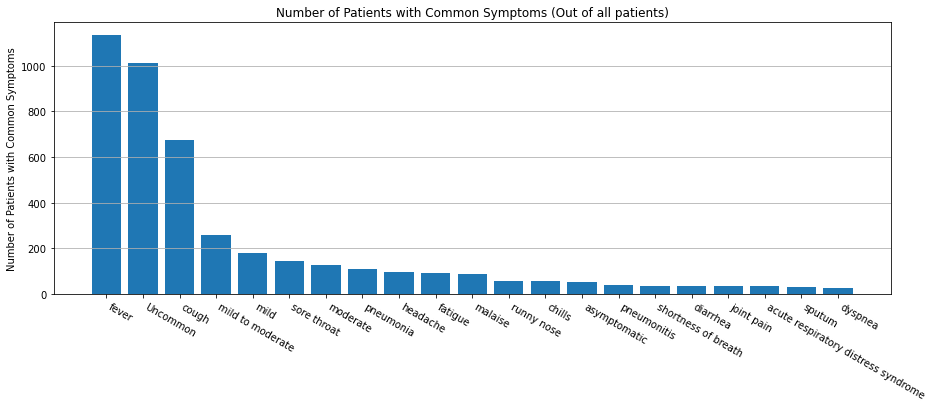

In [28]:
plot_symptom_counts(linelistrecord_df, title="Number of Patients with Common Symptoms (Out of all patients)")

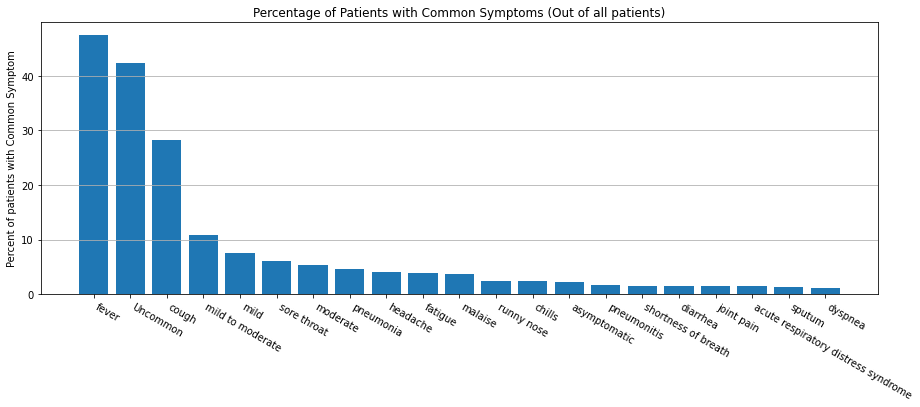

In [30]:
plot_symptom_percentages(linelistrecord_df, title="Percentage of Patients with Common Symptoms (Out of all patients)")

### Restrict the dataset to those entries containing outcome, symptom, age, and death information.

In [33]:
more_complete_subset_df = linelistrecord_df[linelistrecord_df.outcome.notna() & linelistrecord_df.age.notna() & linelistrecord_df.didDie.notna() & linelistrecord_df.didRecover.notna() & (linelistrecord_df.didRecover | linelistrecord_df.didDie)]

In [34]:
more_complete_subset_df

,type,id,meta,version,age,gender,symptoms,hospitalAdmissionDate,caseConfirmationDate,ageRange,outcome,didDie,didRecover,outcomeDate
133,LineListRecord,000-1-129,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,44.0,female,"fatigue, fever",2020-01-15T00:00:00+00:00,2020-01-21T00:00:00+00:00,NaN,discharged,False,True,2020-01-29T00:00:00+00:00
137,LineListRecord,000-1-130,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,39.0,female,"systemic weakness, runny nose, fever",2020-01-22T00:00:00+00:00,2020-01-24T00:00:00+00:00,NaN,discharged,False,True,2020-02-03T00:00:00+00:00
139,LineListRecord,000-1-131,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,46.0,male,fever,2020-01-17T00:00:00+00:00,2020-01-21T00:00:00+00:00,NaN,discharged,False,True,NaN
164,LineListRecord,000-1-133,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,40.0,male,"fever, pneumonia, sore throat",2020-01-20T00:00:00+00:00,2020-01-24T00:00:00+00:00,NaN,discharged,False,True,NaN
171,LineListRecord,000-1-134,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,30.0,male,"cough, fever, sore throat",2020-01-10T00:00:00+00:00,2020-01-15T00:00:00+00:00,NaN,discharged,False,True,2020-01-15T00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,LineListRecord,004-1139,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,57.0,female,significant clinical suspicion,NaN,2020-03-24T00:00:00+00:00,NaN,died,True,False,NaN
1928,LineListRecord,004-1302,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,61.0,male,"fever, cough, running nose",2020-02-25T00:00:00+00:00,2020-02-26T00:00:00+00:00,NaN,discharged,False,True,NaN
1929,LineListRecord,004-1303,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,32.0,male,"fever, cough, sore throat, mialgia, headache",2020-02-28T00:00:00+00:00,2020-02-28T00:00:00+00:00,NaN,discharged,False,True,NaN
1962,LineListRecord,004-20582,"{'type': 'Meta', 'fetchInclude': '[symptoms,ge...",65537,52.0,female,"severe, kidney failure and hypertension",NaN,2020-03-11T00:00:00+00:00,NaN,death,True,False,2020-03-11T00:00:00+00:00


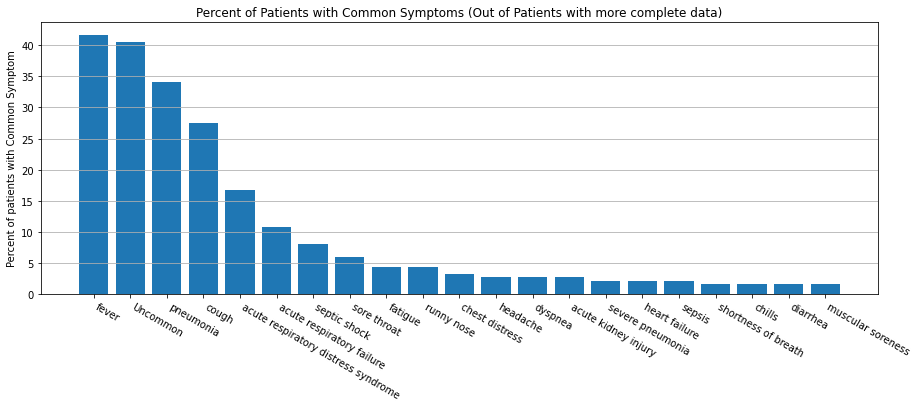

In [35]:
plot_symptom_percentages(more_complete_subset_df, title="Percent of Patients with Common Symptoms (Out of Patients with more complete data)")

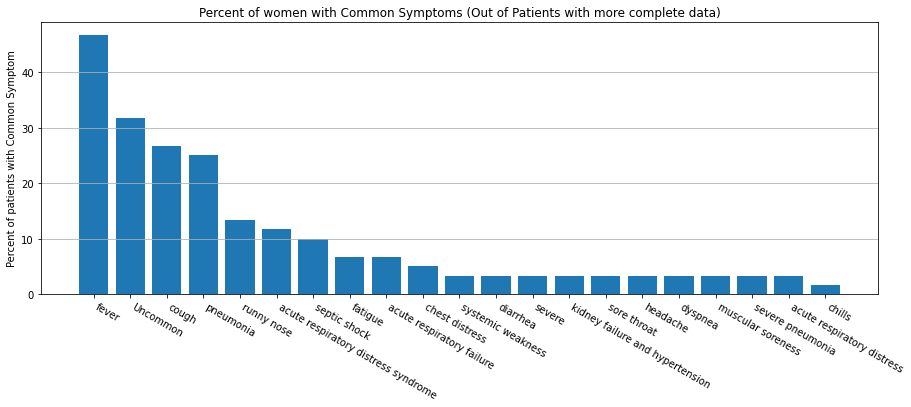

In [36]:
plot_symptom_percentages(more_complete_subset_df[more_complete_subset_df.gender == 'female'],
                         title="Percent of women with Common Symptoms (Out of Patients with more complete data)")

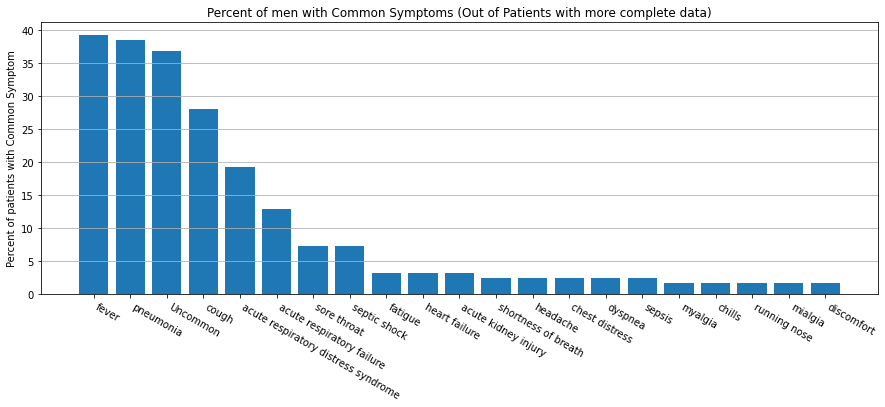

In [37]:
plot_symptom_percentages(more_complete_subset_df[more_complete_subset_df.gender == 'male'],
                         title="Percent of men with Common Symptoms (Out of Patients with more complete data)")

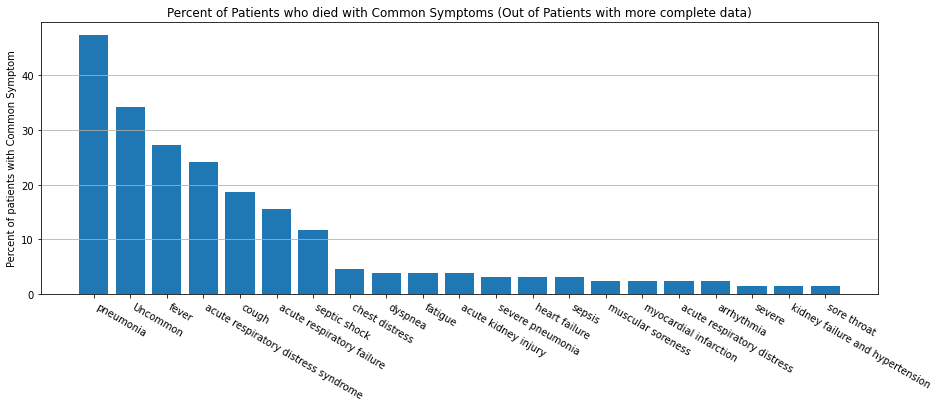

In [38]:
plot_symptom_percentages(more_complete_subset_df[more_complete_subset_df.didDie.astype(bool)],
                         title="Percent of Patients who died with Common Symptoms (Out of Patients with more complete data)")

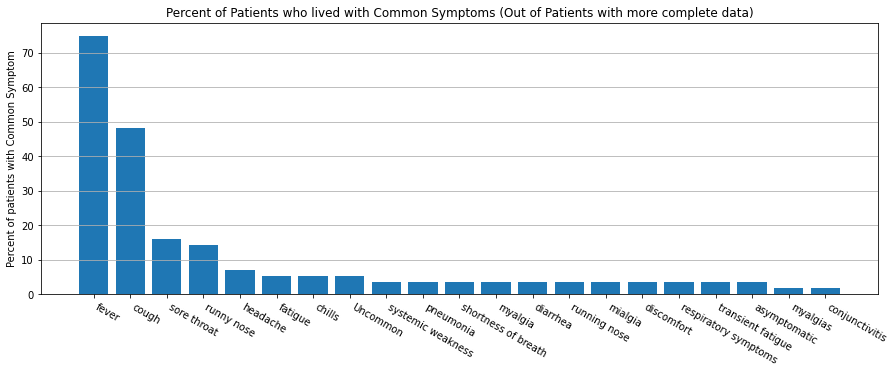

In [39]:
plot_symptom_percentages(more_complete_subset_df[~(more_complete_subset_df.didDie.astype(bool))],
                         title="Percent of Patients who lived with Common Symptoms (Out of Patients with more complete data)")